# This notebook illustrates advantages of using prior weights

In [1]:
using Revise
using MendelIHT
using SnpArrays
using DataFrames
using Distributions
using BenchmarkTools
using Random
using LinearAlgebra
using GLM
using StatsPlots

┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.0/MendelIHT/eaqWB.ji for MendelIHT [921c7187-1484-5754-b919-5d3ed9ac03c4]
└ @ Base loading.jl:1190


In [18]:
function compare(n::Int, p::Int, k::Int, d::UnionAll, l::Link)
    # construct snpmatrix, covariate files, and true model b
    x = simulate_random_snparray(n, p, "tmp.bed")
    xbm = SnpBitMatrix{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true); 
    z = ones(n, 1) # the intercept
    
    #define true_b 
    true_b = zeros(p)
    true_b[1:10] .= collect(0.1:0.1:1.0)
    shuffle!(true_b)
    correct_position = findall(!iszero, true_b)

    #simulate phenotypes (e.g. vector y)
    if d == Normal || d == Poisson || d == Bernoulli
        prob = linkinv.(l, xbm * true_b)
        clamp!(prob, -20, 20)
        y = [rand(d(i)) for i in prob]
    elseif d == NegativeBinomial
        nn = 10
        μ = linkinv.(l, xbm * true_b)
        clamp!(μ, -20, 20)
        prob = 1 ./ (1 .+ μ ./ nn)
        y = [rand(d(nn, i)) for i in prob] #number of failtures before nn success occurs
    elseif d == Gamma
        μ = linkinv.(l, xbm * true_b)
        β = 1 ./ μ # here β is the rate parameter for gamma distribution
        y = [rand(d(α, i)) for i in β] # α is the shape parameter for gamma
    end
    y = Float64.(y)
    
    # construct weight vector
    w = ones(p + 1)
    w[correct_position] .= 2.0
    one_tenth = round(Int, p/10)
    idx = rand(1:p, one_tenth)
    w[idx] .= 2.0 #randomly set ~1/10 of all predictors to 2

    #run IHT
    unweighted = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=false, init=false, use_maf=false)
    weighted   = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=false, init=false, use_maf=false, weight=w)

    #check result
    compare_model = DataFrame(
        position    = correct_position,
        correct     = true_b[correct_position],
        unweighted  = unweighted.beta[correct_position], 
        weighted    = weighted.beta[correct_position])
    @show compare_model
    println("\n")

    #clean up
    rm("tmp.bed", force=true)
    
    unweighted_found = count(!iszero, unweighted.beta[correct_position])
    weighted_found = count(!iszero, weighted.beta[correct_position])
    return unweighted_found, weighted_found
end

compare (generic function with 1 method)

In [19]:
function run(d::UnionAll, l::Link)
    #simulat data with k true predictors, from distribution d and with link l.
    n = 1000
    p = 10000
    k = 10

    unweighted_found = 0
    weighted_found = 0
    for i in 1:50
        uf, wf = compare(n, p, k, d, l)
        unweighted_found += uf
        weighted_found += wf
    end
    println("\n")
    println(string(d) * ": unweighted IHT found $unweighted_found")
    println(string(d) * ": weighted IHT found $weighted_found")
    println("\n")
end

run (generic function with 1 method)

In [20]:
Random.seed!(2019)

pairs = [(NegativeBinomial, LogLink()),
         (Normal, IdentityLink()), 
         (Bernoulli, LogitLink()),
         (Poisson, LogLink())]
for pair in pairs
    run(pair[1], pair[2])
end

compare_model = 10×4 DataFrame
│ Row │ position │ correct │ unweighted │ weighted │
│     │ Int64    │ Float64 │ Float64    │ Float64  │
├─────┼──────────┼─────────┼────────────┼──────────┤
│ 1   │ 844      │ 0.3     │ 0.29355    │ 0.295105 │
│ 2   │ 868      │ 0.1     │ 0.0        │ 0.109208 │
│ 3   │ 915      │ 0.5     │ 0.421378   │ 0.420442 │
│ 4   │ 2692     │ 0.7     │ 0.626272   │ 0.62946  │
│ 5   │ 4234     │ 0.4     │ 0.369065   │ 0.365865 │
│ 6   │ 4775     │ 1.0     │ 0.93151    │ 0.927383 │
│ 7   │ 5086     │ 0.6     │ 0.504783   │ 0.514322 │
│ 8   │ 5276     │ 0.8     │ 0.682583   │ 0.681523 │
│ 9   │ 7747     │ 0.9     │ 0.854634   │ 0.862199 │
│ 10  │ 8248     │ 0.2     │ 0.15975    │ 0.16275  │


compare_model = 10×4 DataFrame
│ Row │ position │ correct │ unweighted │ weighted │
│     │ Int64    │ Float64 │ Float64    │ Float64  │
├─────┼──────────┼─────────┼────────────┼──────────┤
│ 1   │ 192      │ 0.9     │ 0.792927   │ 0.792739 │
│ 2   │ 2245     │ 0.7     │ 0.6665

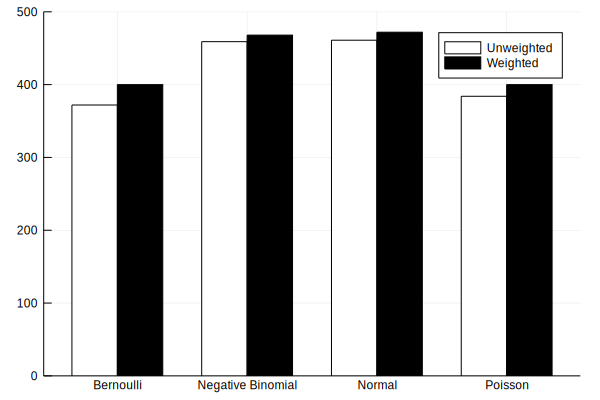

In [25]:
found = [461 472; 372 400; 384 400; 459 468]
category = repeat(["Unweighted", "Weighted"], inner = 4)
bar_color = [:white, :white, :white, :white, :black, :black, :black, :black, ]
name = repeat(["Normal", "Bernoulli", "Poisson", "Negative Binomial"], outer = 2)
groupedbar(name, found, group = category, bar_position = :dodge, bar_width=0.7, 
    color = bar_color, ylim = (0, 500))

In [26]:
hi = groupedbar(name, found, group = category, bar_position = :dodge, bar_width=0.7, 
    color = bar_color, ylim = (0, 500), dpi=300)
StatsPlots.savefig(hi, "weight_plot")